In [1]:
# invenotries-trained model
import tensorflow as tf

model = tf.keras.models.load_model('./model_1.h5')
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_layer (Flatten)      (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [2]:
# invenotries-dataset images
# param=28
import gzip
import numpy as np

dataset_dir = '.'

def load_img(file_name):
    file_path = dataset_dir + '/' + file_name
    with gzip.open(file_path, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, 28, 28)
    return data


dataset = {}
dataset['test_img'] = load_img('t10k-images-idx3-ubyte.gz')
dataset['test_img'].shape


(10000, 28, 28)

In [3]:
# invenotries-dataset labels

def load_label(file_name):
    file_path = dataset_dir + '/' + file_name
    with gzip.open(file_path, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)
    return labels

dataset['test_label'] = load_label('t10k-labels-idx1-ubyte.gz')
dataset['test_label'].shape

(10000,)

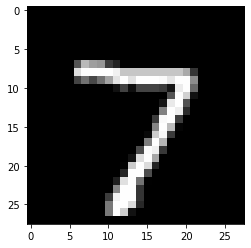

7

In [4]:
import matplotlib.pyplot as plt

example = dataset['test_img'][0]

plt.imshow(example, cmap = "gray")
plt.show()

dataset['test_label'][0] 

In [5]:
print(type(dataset['test_img']))

print(dataset['test_img'].shape)

print(dataset['test_img'].dtype)

print(dataset['test_img'].min(), '-', dataset['test_img'].max())

<class 'numpy.ndarray'>
(10000, 28, 28)
uint8
0 - 255


In [6]:
# 前処理として、画像を最大値255で割って0.0 - 1.0に規格化する。

dataset['test_img'] = dataset['test_img'] / 255

print(dataset['test_img'].dtype)
# float64

print(dataset['test_img'].min(), '-', dataset['test_img'].max())
# 0.0 - 1.0

float64
0.0 - 1.0


In [7]:
# 評価

predictions = model.predict(dataset['test_img'])

print(type(predictions))
# <class 'numpy.ndarray'>

print(predictions.shape)
# (10000, 10)


<class 'numpy.ndarray'>
(10000, 10)


In [65]:
from functools import partial

import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical

# y_predの正規化
def normalize_y_pred(y_pred):
    return K.one_hot(K.argmax(y_pred), y_pred.shape[-1])

def class_true_positive(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label] + y_pred[:, class_label], 2),
                  K.floatx())

def true_positive(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true + y_pred, 2),
                  K.floatx())

def class_precision(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_pred[:, class_label]) + K.epsilon())

def micro_precision(y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_pred) + K.epsilon())

def macro_precision(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_precision(i, y_true, y_pred) for i in range(class_count)]) \
           / K.cast(class_count, K.floatx())

def class_recall(class_label, y_true, y_pred):
    return K.sum(class_true_positive(class_label, y_true, y_pred)) / (K.sum(y_true[:, class_label]) + K.epsilon())

def micro_recall(y_true, y_pred):
    return K.sum(true_positive(y_true, y_pred)) / (K.sum(y_true) + K.epsilon())

def macro_recall(y_true, y_pred):
    class_count = y_pred.shape[-1]
    return K.sum([class_recall(i, y_true, y_pred) for i in range(class_count)]) \
           / K.cast(class_count, K.floatx())

def class_accuracy(class_label, y_true, y_pred):
    y_pred = normalize_y_pred(y_pred)
    return K.cast(K.equal(y_true[:, class_label], y_pred[:, class_label]),
                  K.floatx())

def average_accuracy(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    class_acc_matrix = K.concatenate(class_acc_list, axis=0)
    return K.mean(class_acc_matrix, axis=0)

def class_f_measure(class_label, y_true, y_pred):
    precision = class_precision(class_label, y_true, y_pred)
    recall = class_recall(class_label, y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

def micro_f_measure(y_true, y_pred):
    precision = micro_precision(y_true, y_pred)
    recall = micro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

def macro_f_measure(y_true, y_pred):
    precision = macro_precision(y_true, y_pred)
    recall = macro_recall(y_true, y_pred)
    return (2 * precision * recall) / (precision + recall + K.epsilon())

one_hot_y = to_categorical(dataset['test_label'])

json = {
    'average_accuracy': average_accuracy(one_hot_y, predictions),
    'micro_precision': micro_precision(one_hot_y, predictions),
    'macro_precision': macro_precision(one_hot_y, predictions),
    'micro_recall': micro_recall(one_hot_y, predictions),
    'macro_recall': macro_recall(one_hot_y, predictions),
    'micro_f_measure': micro_f_measure(one_hot_y, predictions),
    'macro_f_measure': macro_f_measure(one_hot_y, predictions)
}

print(json)

for i in range(10):
    a = class_accuracy(i, one_hot_y, predictions)
    print(a.shape)
    print(a)
    print(np.mean(a))
# print('average_accuracy: ' + average_accuracy(one_hot_y, predictions))
# print('micro_precision: ' + micro_precision(one_hot_y, predictions))
# print('macro_precision: ' + macro_precision(one_hot_y, predictions))
# print('micro_recall: ' + micro_recall(one_hot_y, predictions))
# print('macro_recall: ' + macro_recall(one_hot_y, predictions))
# print('micro_f_measure: ' + micro_f_measure(one_hot_y, predictions))
# print('macro_f_measure: ' + macro_f_measure(one_hot_y, predictions))

{'average_accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.99588>, 'micro_precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.9794>, 'macro_precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.9793>, 'micro_recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.9794>, 'macro_recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.9791662>, 'micro_f_measure': <tf.Tensor: shape=(), dtype=float32, numpy=0.9793999>, 'macro_f_measure': <tf.Tensor: shape=(), dtype=float32, numpy=0.979233>}
(10000,)
tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(10000,), dtype=float32)
0.997
(10000,)
tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(10000,), dtype=float32)
0.998
(10000,)
tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(10000,), dtype=float32)
0.9959
(10000,)
tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(10000,), dtype=float32)
0.9955
(10000,)
tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(10000,), dtype=float32)
0.9961
(10000,)
tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(10000,), dtype=float32)
0.996
(10000,)


In [9]:
# 混同行列
!pip install sklearn
from sklearn.metrics import confusion_matrix

y_true = dataset['test_label']
y_pred = K.argmax(predictions)

confusion_matrix = confusion_matrix(y_true, y_pred)
print(type(confusion_matrix))
print(confusion_matrix.shape)
print(confusion_matrix)

np.savetxt('confusion_matrix.csv', confusion_matrix, fmt='%d', delimiter=',')

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
<class 'numpy.ndarray'>
(10, 10)
[[ 968    0    1    1    0    1    6    1    2    0]
 [   0 1127    2    1    0    0    2    1    2    0]
 [   3    2 1015    0    1    0    3    5    2    1]
 [   0    0    3  991    0    6    0    4    3    3]
 [   0    0    3    1  960    0    7    1    1    9]
 [   3    0    0    7    1  869    5    2    3    2]
 [   4    2    1    1    1    5  944    0    0    0]
 [   1    6   11    1    1    0    0 1002    1    5]
 [   5    0    3    8    4    3    4    4  939    4]
 [   2    2    0    6    9    2    1    5    3  979]]


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


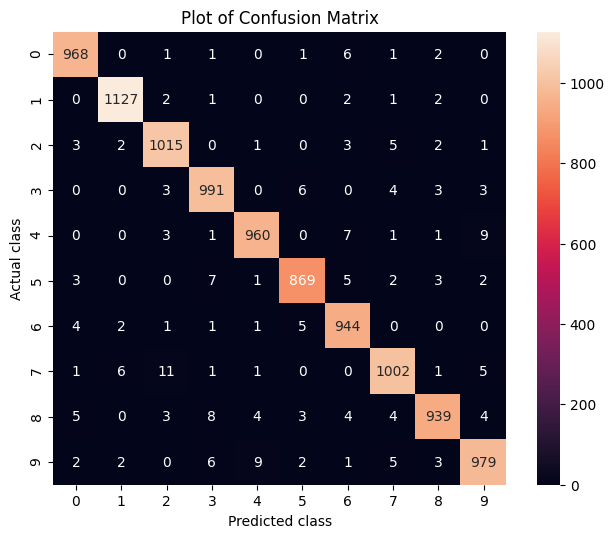

In [10]:
!pip install pandas
!pip install seaborn 

import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
 
def print_cmx(y_true, y_pred):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig = plt.figure(dpi=100, figsize=(8,6))
    sn.heatmap(df_cmx, annot=True, fmt='g' ,square = True)
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('Actual class')
    ax.set_title('Plot of Confusion Matrix')

    # save as png
    plt.savefig('confusin_matrix.png')
    plt.show()
 
y_true = dataset['test_label']
y_pred = K.argmax(predictions)

print_cmx(y_true, y_pred)

[0.         0.         0.         ... 0.99977827 0.99988914 1.        ]
[0.         0.20204082 0.26122449 ... 1.         1.         1.        ]
0.9998720530340739
[0.         0.         0.         ... 0.99977439 0.9998872  1.        ]
[0.         0.01057269 0.02378855 ... 1.         1.         1.        ]
0.9999073722081839
[0.         0.         0.         ... 0.99977698 0.99988849 1.        ]
[0.         0.11918605 0.15697674 ... 1.         1.         1.        ]
0.9997314417671099
[0.         0.         0.         ... 0.99977753 0.99988877 1.        ]
[0.         0.09306931 0.14950495 ... 1.         1.         1.        ]
0.9996215817354817
[0.         0.         0.         ... 0.99977822 0.99988911 1.        ]
[0.         0.15784114 0.21486762 ... 1.         1.         1.        ]
0.9996476835873399
[0.         0.         0.         ... 0.99978041 0.99989021 1.        ]
[0.         0.19955157 0.25784753 ... 1.         1.         1.        ]
0.9997895212605683
[0.         0.        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


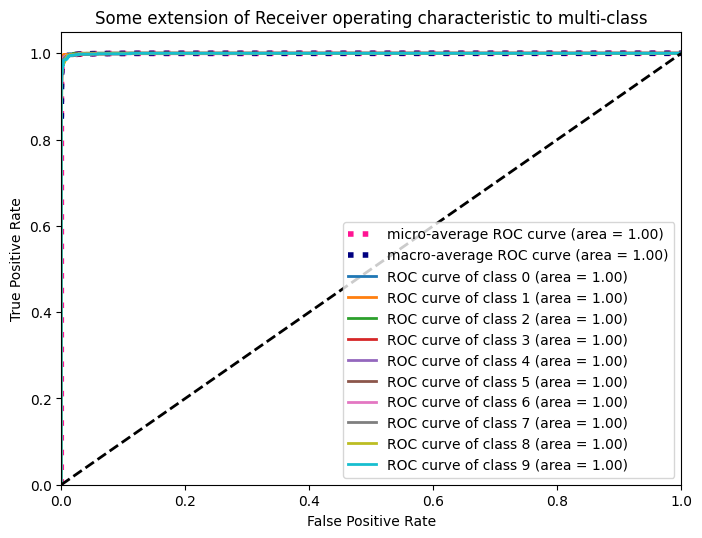

One-vs-One ROC AUC scores:
0.999675 (macro),
0.999677 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.999675 (macro),
0.999677 (weighted by prevalence)


In [11]:
# RCC曲線
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp
import matplotlib.pyplot as plt
import numpy as np
import random
from itertools import cycle

# ★param class_number
n_classes=10

y_true = to_categorical(dataset['test_label'])
y_score = predictions

fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(fpr[i])
    print(tpr[i])
    print(roc_auc[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(dpi=100, figsize=(8,6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['#1f77b4',
                '#ff7f0e',
                '#2ca02c',
                '#d62728',
                '#9467bd',
                '#8c564b',
                '#e377c2',
                '#7f7f7f',
                '#bcbd22',
                '#17becf'])

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()


macro_roc_auc_ovo = roc_auc_score(y_true, y_score, multi_class="ovo",
                                  average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_true, y_score, multi_class="ovo",
                                     average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_true, y_score, multi_class="ovr",
                                  average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_true, y_score, multi_class="ovr",
                                     average="weighted")
print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
      "(weighted by prevalence)"
      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))

10000


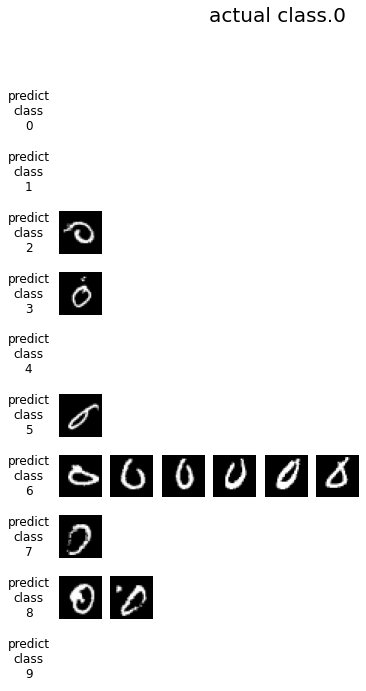

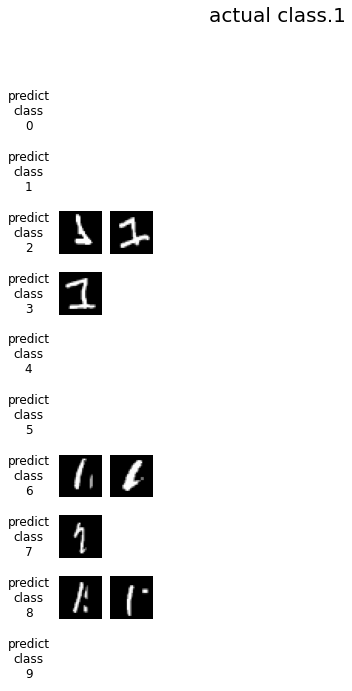

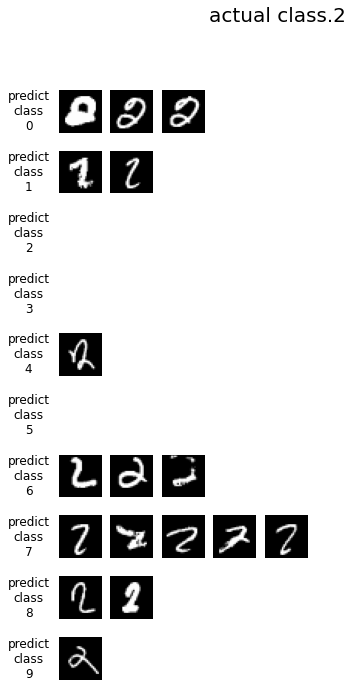

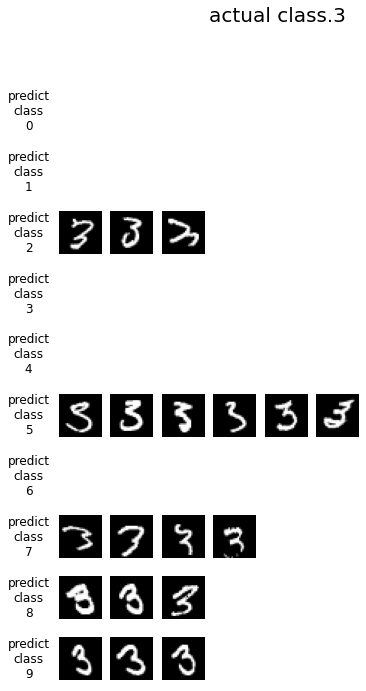

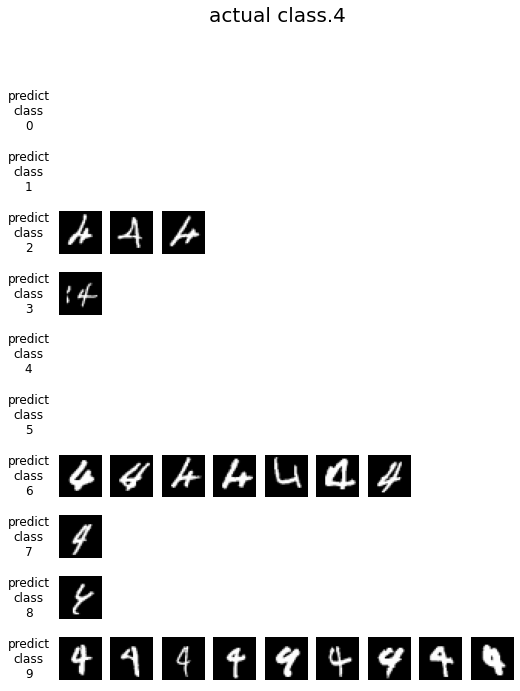

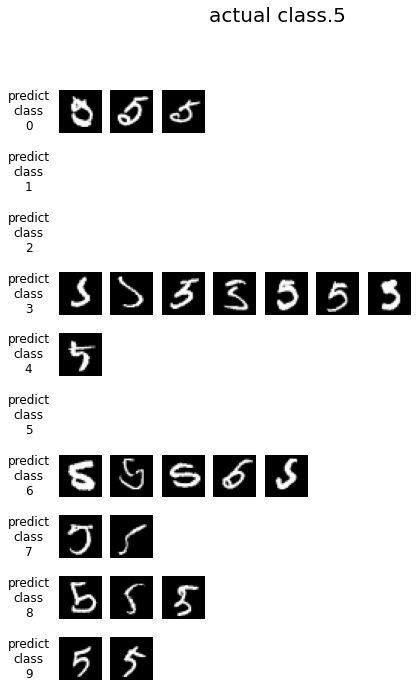

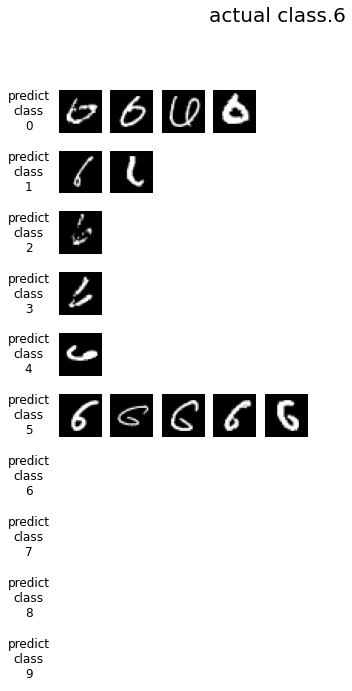

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


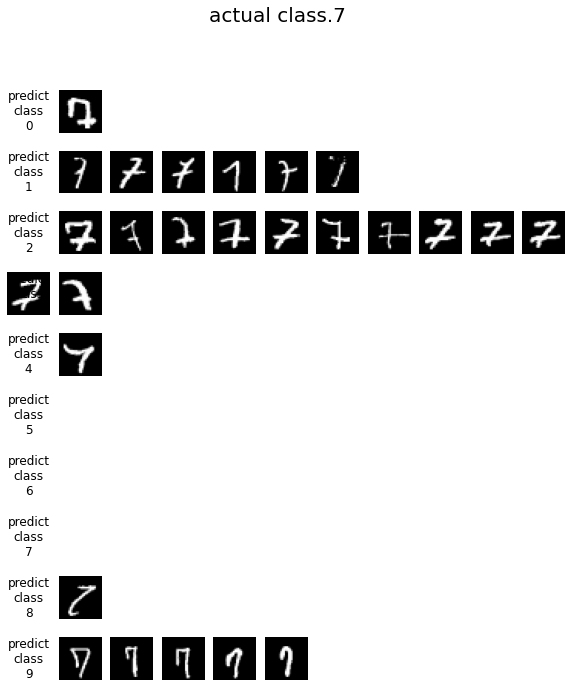

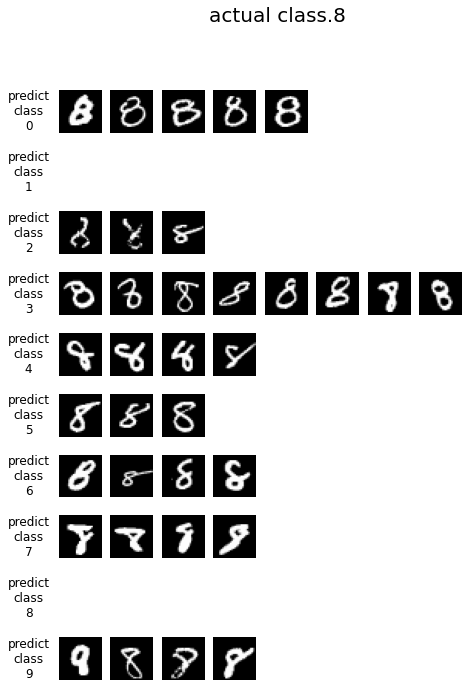

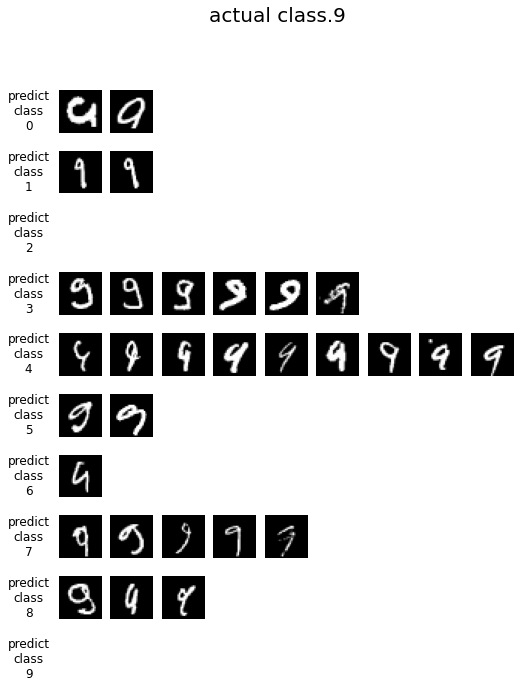

In [12]:
# FP・FN

y_true = dataset['test_label']
y_pred = K.argmax(predictions)

# # ★param class_number
n_classes=10

# unmach_classes={label:[{predict: index}] }
unmach_classes={}
for actual_class_no in range(n_classes):
    unmach_classes[actual_class_no] = {}
    for predict_class_no in range(n_classes):
        unmach_classes[actual_class_no][predict_class_no] = []

print (y_pred.shape[-1])

for i in range(y_pred.shape[-1]):
    if y_true[i] != y_pred[i].numpy():
        unmach_classes[y_true[i]][y_pred[i].numpy()].append(i)

X_test = load_img('t10k-images-idx3-ubyte.gz')

# visualization
def draw_digit(data, row, col, n):
    ax = plt.subplot(row, col, n)
    ax.axis("off")
    plt.imshow(data, cmap = "gray")

def draw_text(text, row, col, n):
    ax = plt.subplot(row, col, n)
    ax.axis("off")

    # build a rectangle in axes coords
    left, width = .25, .5
    bottom, height = .25, .5
    right = left + width
    top = bottom + height
    ax.text(0.5*(left+right), 0.5*(bottom+top), text,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=12, color='black',
        transform=ax.transAxes)

show_size = 10 + 1
for actual_class_no in range(n_classes):
    fig = plt.figure(figsize=(n_classes,show_size))
    fig.suptitle('actual class.{}'.format(actual_class_no), fontsize=20)
    unmachies = unmach_classes[actual_class_no]
    for predict_class_no in range(n_classes):
        indexes = unmach_classes[actual_class_no][predict_class_no]
        # print(indexes)
        offset = predict_class_no * show_size + 1
        draw_text('predict\nclass\n{}'.format(predict_class_no), n_classes, show_size, offset)
        for index in indexes:
            offset += 1
            draw_digit(X_test[index], n_classes, show_size, offset)
#             # 10枚分以上は読み捨て
#             if offset % 10 == 0:
#                 break;
    plt.savefig('ng_predict__actual_class_{}.png'.format(actual_class_no))
    plt.show()


In [42]:
y_test = dataset['test_label']
y_pred = predictions

print(type(y_test))
print(y_test.shape)
print(type(y_pred))
print(y_pred.shape)
print(y_pred.shape[1])

print(y_test[0])
print(y_pred[0])

print(y_test.shape[0])
y_test_2 = y_test.reshape(y_test.shape[0], 1)
print(y_test_2)

out = np.hstack([y_test_2, y_pred])

index = [str(i) for i in range(1,10001)]
columns = ['Label']+[f'PredictionProva_Class_{i}' for i in range(1,11)]
print(len(index))
print(columns)

df = pd.DataFrame(data=out, index=index, columns=columns, dtype='float')
df.to_csv('y_pred.csv')


<class 'numpy.ndarray'>
(10000,)
<class 'numpy.ndarray'>
(10000, 10)
10
7
[1.8167063e-11 1.3358716e-10 8.7301466e-08 1.8851786e-04 4.2914701e-14
 3.3778604e-09 4.4891751e-15 9.9981123e-01 6.3214472e-08 8.6266766e-08]
10000
[[7]
 [2]
 [1]
 ...
 [4]
 [5]
 [6]]
10000
['Label', 'PredictionProva_Class_1', 'PredictionProva_Class_2', 'PredictionProva_Class_3', 'PredictionProva_Class_4', 'PredictionProva_Class_5', 'PredictionProva_Class_6', 'PredictionProva_Class_7', 'PredictionProva_Class_8', 'PredictionProva_Class_9', 'PredictionProva_Class_10']


In [31]:
a1 = np.ones(2, int)
print(a1)
a1 = a1.reshape(2, 1)
print(a1)

a2 = np.full((2, 3), 2)
print(a2)

print(np.hstack([a1, a2]))
# [[1 1 1 2 2 2]
#  [1 1 1 2 2 2]]

[1 1]
[[1]
 [1]]
[[2 2 2]
 [2 2 2]]
[[1 2 2 2]
 [1 2 2 2]]


In [59]:
def all_class_accuracy(y_true, y_pred):
    return [class_accuracy(i, y_true, y_pred) for i in range( y_pred.shape[-1])]

def all_class_accuracy2(y_true, y_pred):
    class_count = y_pred.shape[-1]
    class_acc_list = [class_accuracy(i, y_true, y_pred) for i in range(class_count)]
    return K.concatenate(class_acc_list, axis=0)

one_hot_y = to_categorical(dataset['test_label'])

# print(all_class_accuracy(one_hot_y, predictions))
# print(all_class_accuracy2(one_hot_y, predictions))

print(class_accuracy(0,one_hot_y, predictions))

a1 = all_class_accuracy(one_hot_y, predictions)
print(a1)

x1 = [a.numpy() for a in all_class_accuracy(one_hot_y, predictions)]
print(x1)

# print(','.join(map(str,x1)))
# print(','.join(map(str,x1)))

# x2 = [a.numpy() for a in all_class_accuracy2(one_hot_y, predictions)]
# print(len(x2))
# print(','.join(map(str,x2)))



tf.Tensor([1. 1. 1. ... 1. 1. 1.], shape=(10000,), dtype=float32)
[<tf.Tensor: shape=(10000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Tensor: shape=(10000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Tensor: shape=(10000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Tensor: shape=(10000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Tensor: shape=(10000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Tensor: shape=(10000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Tensor: shape=(10000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Tensor: shape=(10000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Tensor: shape=(10000,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>, <tf.Te